#### This Script Imports Average CRF File, the computes the best Naka Rushton Parameters via non-linear modeling by SciPy Curve FIt

In [1]:
# load packages
import numpy as np 
import scipy.io
from scipy.fft import fft, ifft
from scipy.io   import  loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime
np.random.seed(9191977) # set seed number

In [2]:
MainDir = 'D:\\AttnXV3_analysis\\RCA_F1\\RCA\\' # set dir
os.chdir(MainDir)
d = os.listdir(MainDir) # list files in dir
print(d)
FileN = (d[0]) # choose one
file_path = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Dir:',file_path) # does path exist ... ?
print('Does Path Exist?',os.path.exists(file_path)) # yes or no

['rcaResults_Sweep_contrast_sweeps.mat', 'previous_rcaResults_contrast sweeps_sweep.mat', 'nr_tut.mat']
Dir: D:\AttnXV3_analysis\RCA_F1\RCA\rcaResults_Sweep_contrast_sweeps.mat
Does Path Exist? True


In [3]:
InDataDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir where avg crf were be saved
FileOps = os.listdir(InDataDir) # list files in dir
print(FileOps) #list file names .. too long to type out
###################
dataIn = FileOps[4]
print('Selected File:', dataIn)
ImportFile = os.path.join(InDataDir,dataIn)
print(ImportFile)
print('Does File Exist?', os.path.exists(ImportFile))

['F1AverageCRF_20240205_154708.pkl', 'F1AverageCRF_20240205_162024.mat', 'F1AverageCRF_20240205_162024.pkl', 'F1AverageCRF_20240206_104806.pkl', 'F1AverageCRF_20240207_124816.pkl']
Selected File: F1AverageCRF_20240207_124816.pkl
D:\AttnXV3_analysis\RCA_F1\AvgCRFs\F1AverageCRF_20240207_124816.pkl
Does File Exist? True


In [4]:
SaveFigDir = 'D:\\AttnXV3_analysis\\F1NRushPlots\\'
SubFoldName = 'NR_Sims_pres_NoSat' # can change folder name to add to another folder now
newPath = os.path.join(SaveFigDir,SubFoldName)
if not os.path.exists(newPath):
    os.makedirs(newPath)
print('Path to Save Figures is:',newPath) 

Path to Save Figures is: D:\AttnXV3_analysis\F1NRushPlots\NR_Sims_pres_NoSat


In [5]:
loadData = pkl.load(open(ImportFile, 'rb'))
print(loadData.keys())
crf = loadData['OriginalCRF']
ns_crf = loadData['NoSatCRF']
avg_crf = loadData['avgCRF']
avg_crf_ns = loadData['NoSatavgCRF']

FName =  loadData['FileNames']

dict_keys(['OriginalCRF', 'NoSatCRF', 'avgCRF', 'NoSatavgCRF', 'FileNames'])


In [6]:
NumSubs = int(len(crf.keys()))
print('Average CRFs Loaded for',NumSubs,'Subjects')

Average CRFs Loaded for 55 Subjects


##### Segment Arrays into Pre and Post Manner

In [7]:
allCRF = dict()

for i in range(NumSubs):
    data = crf[i]
    [cols, rows] = data.shape
    crfs = np.zeros((int(rows*2),int(cols/2)))
    # Pre Data
    crfs[0,:] = data[:6,0] # 2F
    crfs[1,:] = data[6:,0] # 4F
    # Post Data
    crfs[2,:] = data[:6,1] # 2F
    crfs[3,:] = data[6:,1] # 4F

    allCRF[i] = crfs # 4 x 6 array


In [8]:
c  = sns.color_palette("Paired",12) 
sns.color_palette("Paired",12)

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

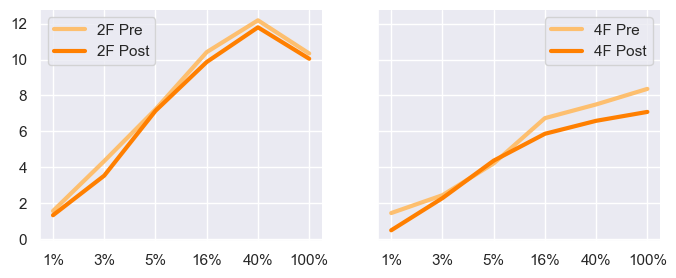

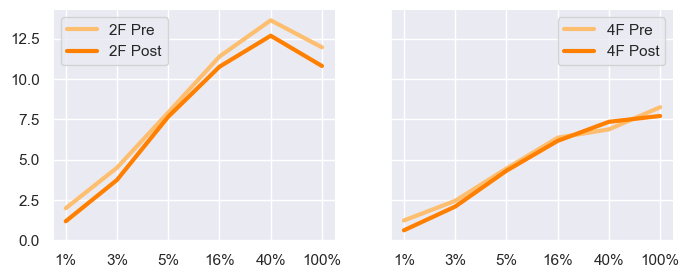

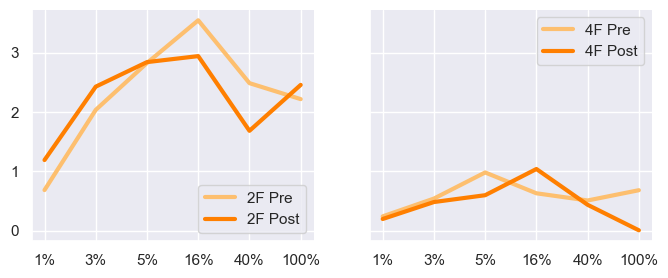

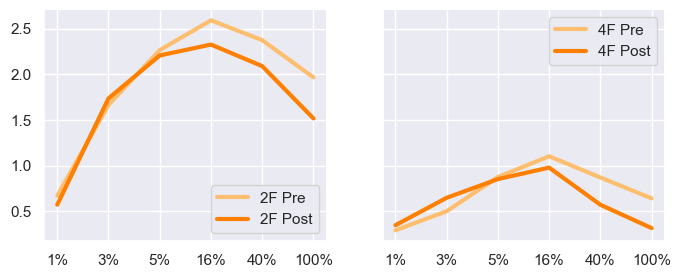

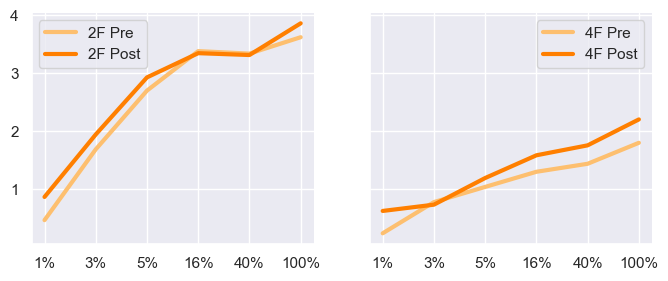

In [9]:
contrast_levels_labs=['1%', '3%', '5%', '16%', '40%', '100%']
sns.set_theme()
for j in range(5):#(NumSubs):
    fig, axs = plt.subplots(1,2, figsize=(8, 3), sharey = True)
    axs[0].plot(allCRF[j][0,:], color = c[6], linewidth = 3, label = '2F Pre')
    axs[0].plot(allCRF[j][2,:], color = c[7], linewidth = 3, label = '2F Post')
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].set_xticks(range(len(contrast_levels_labs)))
    axs[0].set_xticklabels(contrast_levels_labs)
    axs[0].legend()

    axs[1].plot(allCRF[j][1,:], color = c[6], linewidth = 3, label = '4F Pre')
    axs[1].plot(allCRF[j][3,:], color = c[7], linewidth = 3, label = '4F Post')
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].set_xticks(range(len(contrast_levels_labs)))
    axs[1].set_xticklabels(contrast_levels_labs)
    axs[1].legend()
    plt.show()

# Naka Rushton Model Function

In [10]:
# function to model curve
def naka_rushton(C, C50, n, Rmax, b):
### This function models Contrast Response Functions 
### C50(parameter 1):Contrast level that yields half of max reponse (contrast %)
### n(parameter 2)  :Determines the curve arc for fitting (small #int)
### Rmax(Parameter3):Max response elicited (mv)
### b(Parameter 4)  :starting value (origin #)
    return ((Rmax * ((C**n) / (C50**n + C**n)))+b)

# Set Scipy Params for Curve Fit

In [11]:
param_names=['C50','n','Rmax','b']
contrast_levels=np.array([1, 3, 5, 16, 40, 100])
contrast_levels_labs=['1%', '3%', '5%', '16%', '40%', '100%']

## Run Model for Optimal Params to fit Naka Rushton Function

In [12]:
pre_opt_params = np.zeros((NumSubs,4)) # [ith subj x params]
post_opt_params = np.copy((pre_opt_params))
pre_opt_ps = np.copy((pre_opt_params)) # [ith subj x params]
post_opt_ps = np.copy((pre_opt_params))

In [13]:
### Model Estimates...based on nothing soild - subject to change 
c50_b = [0,300]
n_b = [0,5] # [0,10]
Rmax_b = [0,10] # [0,10]
b_b = [0,3]
boundaries=([c50_b[0],n_b[0],Rmax_b[0],b_b[0]], [c50_b[1],n_b[1],Rmax_b[1],b_b[1]]) # Boundary Params for C50, N, Rmax and B
init_g1 = [20,3,4,0.5]
init_g2 = [10,1,2,0.5]

for k in range(NumSubs):    
    # Fit the Naka-Rushton function to the data
    preMain_popt, premainco = curve_fit(naka_rushton,contrast_levels,allCRF[k][0,:],p0=init_g1,bounds=boundaries,nan_policy='omit',method='trf') #bounds = boundaries
    postMain_popt, postmaincov = curve_fit(naka_rushton,contrast_levels,allCRF[k][2,:],p0=init_g1,bounds=boundaries,nan_policy='omit',method='trf') #bounds = boundaries

    pre_popt, precov = curve_fit(naka_rushton,contrast_levels,allCRF[k][1,:],p0=init_g2,bounds=boundaries,nan_policy='omit',method='trf') #bounds = boundaries
    post_popt, postcov = curve_fit(naka_rushton,contrast_levels,allCRF[k][3,:],p0=init_g2,bounds=boundaries,nan_policy='omit',method='trf') #bounds = boundaries

    pre_opt_params[k,:]=preMain_popt # [ith subj x params]
    post_opt_params[k,:]=postMain_popt # [ith subj x params]

    pre_opt_ps[k,:]=pre_popt # [ith subj x params]
    post_opt_ps[k,:]=post_popt # [ith subj x params]

### Save Curve Fit Params Into a .pkl file

In [14]:
NR_dict = dict()

NR_dict[0] = pre_opt_params
NR_dict[1] = post_opt_params
NR_dict[2] = pre_opt_params 
NR_dict[3] = post_opt_params
NR_dict['SubjNames'] = FName
NR_dict['init_guess2f'] = init_g1
NR_dict['init_guess4f'] = init_g2
NR_dict['model_bounds'] = boundaries
NR_dict['Paramsorder'] = param_names

print(NR_dict.keys())

dict_keys([0, 1, 2, 3, 'SubjNames', 'init_guess2f', 'init_guess4f', 'model_bounds', 'Paramsorder'])


In [15]:
# Set directory to save NR Data in ..new folder
SaveDataDir = 'D:\\AttnXV3_analysis\\RCA_F1\\HyperRatio_Params\\' # set dir where files (.pkl, .csv) will be saved
FileOutName = 'F1_NR_Params' # make sure this file changes each time you save
######################################################
dnt = datetime.now() # add date and time bc im wreckless when saving ..
fdnt = dnt.strftime("%Y%m%d_%H%M%S") # set the above as a string ...
FileN = f'{FileOutName}_{fdnt}.pkl' 
NewFileNPath = os.path.join(SaveDataDir,FileN)
print('Full New File Dir: ', NewFileNPath)

if not os.path.exists(SaveDataDir):
    os.makedirs(SaveDataDir)
print('Path to Save File is:',SaveDataDir)

Full New File Dir:  D:\AttnXV3_analysis\RCA_F1\HyperRatio_Params\F1_NR_Params_20240207_141329.pkl
Path to Save File is: D:\AttnXV3_analysis\RCA_F1\HyperRatio_Params\


In [ ]:
saveFile = 'n'

if saveFile == 'y':
 with open(NewFileNPath, 'wb') as file:
    pkl.dump(NR_dict, file)
    print('Average CRF Saved! :))')
else:
    print('Did Not Save File! Change file name before switching to y!')

## Visualize Some Naka Rushton Params Generated

In [ ]:
dpi = 150 # img res 
for j in range(NumSubs): #(NumSubs):
    fig, axs = plt.subplots(1,2, figsize=(16, 8), sharey = True)
    # Pre average CRF's
    pltName = (f'F1_HyperRat_Plots_Subj{j+1}Data.png')
    #print(pltName)
    axs[0].set_title('2F1 Average CRF and Naka Rushton Funct',fontsize = 14)
    axs[0].plot(allCRF[j][0,:], color = c[2], linewidth = 5, label = '2F Pre CRF Average')
    axs[0].plot(allCRF[j][2,:], color = c[3], linewidth = 5, label = '2F Post CRF Average')
    # Naka Rushton Params Computed
    pre_params1 = pre_opt_params[j,:]
    post_params1 = post_opt_params[j,:]
    axs[0].plot(naka_rushton(contrast_levels,pre_params1[0],pre_params1[1],pre_params1[2],pre_params1[3]), linewidth = 5,linestyle = '-.',color = c[8],
                label = f'Pre NR Params: C50={pre_params1[0]:.2f}, N={pre_params1[1]:.2f}, rMmax={pre_params1[2]:.2f}, B={pre_params1[3]:.2f}')

    axs[0].plot(naka_rushton(contrast_levels,post_params1[0],post_params1[1],post_params1[2],post_params1[3]), linewidth = 5,linestyle = '-.', color = c[9],
                label = f'Post NR Params: C50={post_params1[0]:.2f}, N={post_params1[1]:.2f}, rMmax={post_params1[2]:.2f}, B={post_params1[3]:.2f}')
    # plotting settings ....
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].set_xticks(range(len(contrast_levels_labs)))
    axs[0].set_xticklabels(contrast_levels_labs)
    axs[0].set_xlabel('Contrast Level')
    axs[0].set_ylabel('Amplitude (mV)')
    axs[0].legend(fontsize = 13, loc = 'lower right')
    ##########################################################################
    #post average CRF's
    axs[1].set_title('4F1 Average CRF and Naka Rushton Funct',fontsize = 14)
    axs[1].plot(allCRF[j][1,:], color = c[2], linewidth = 3, label = '4F Pre CRF Average')
    axs[1].plot(allCRF[j][3,:], color = c[3], linewidth = 3, label = '4F Post CRF Average')
    # Naka Rushton Params Computed
    pre_params2 = pre_opt_ps[j,:]
    post_params2 = post_opt_ps[j,:]
    axs[1].plot(naka_rushton(contrast_levels,pre_params2[0],pre_params2[1],pre_params2[2],pre_params2[3]), linewidth = 5,linestyle = '-.',color = c[8],
                label = f'Pre NR Params: C50={pre_params2[0]:.2f}, N={pre_params2[1]:.2f}, rMmax={pre_params2[2]:.2f}, B={pre_params2[3]:.2f}')

    axs[1].plot(naka_rushton(contrast_levels,post_params2[0],post_params2[1],post_params2[2],post_params2[3]), linewidth = 5,linestyle = '-.', color = c[9],
                label = f'Post NR Params: C50={post_params2[0]:.2f}, N={post_params2[1]:.2f}, rMmax={post_params2[2]:.2f}, B={post_params2[3]:.2f}')
    # plotting settings ....
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].set_xticks(range(len(contrast_levels_labs)))
    axs[1].set_xticklabels(contrast_levels_labs)
    axs[1].set_xlabel('Contrast Level')
    axs[1].set_ylabel('Amplitude (mV)')
    axs[1].legend(fontsize = 13, loc = 'upper left')
    
    if j < 50:
        fig.suptitle(f'CRF and NR Data: {FName[j][:10]}', fontsize = 18)
    else: 
        fig.suptitle(f'CRF and NR Data: {FName[j][:12]}', fontsize = 18)
    #FilePath = os.path.join(newPath,pltName)
    #plt.savefig(FilePath, dpi = dpi)
    plt.show()